# Using STDP to classify the MNIST dataset

In [1]:
%load_ext autoreload
%autoreload 2
# basic libraries
import os
import sys
import time
import numpy as np
import pandas as pd

# graphics libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
import jupyterlab_widgets as lab
from IPython.display import display
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format='retina'
# use NMA plot style
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
plt.style.use('seaborn-v0_8')
my_layout = widgets.Layout()
my_layout.width = '620px'

#machine Learning libraries
import torch
import torch.nn as nn
import snntorch as snn
import snntorch.spikeplot as splt
from snntorch import utils
from snntorch import spikegen

# hyperparameters optimization
import optuna
from optuna.visualization import *
import pickle
import wandb

#import from my scripts
main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)
import importlib

importlib.reload(importlib.import_module('snn_experiments'))
importlib.reload(importlib.import_module('snn_plot_utils'))
importlib.reload(importlib.import_module('snn_models'))
importlib.reload(importlib.import_module('snn_datasets'))
importlib.reload(importlib.import_module('snn_hpo'))

from snn_hpo import *
from snn_experiments import *
from snn_plot_utils import *
from snn_models import *
from snn_datasets import *


# show packages versions for python, numpy, and ipywidgets
print("Python: ", sys.version)
print("Numpy: ", np.__version__)
print("Pandas: ", pd.__version__)
print("jupyterlab_widgets: ", lab.__version__ )
print("IPywidgets: ", widgets.__version__)
print("Torch: ", torch.__version__)
print("Snntorch: ", snn.__version__) # version 0.6.4 before update, current version online 0.7.0
print("Optuna: ", optuna.__version__)
print("Wandb: ", wandb.__version__)
wandb.login()   # 7c8687f416fe1bc5001060ef8ea15242b3aa6fdc

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Python:  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Numpy:  1.26.0
Pandas:  2.1.1
jupyterlab_widgets:  3.0.9
IPywidgets:  8.0.4
Torch:  2.1.0
Snntorch:  0.6.4
Optuna:  3.5.0
Wandb:  0.15.12


wandb: Currently logged in as: lattaruologianmarco (g-latta). Use `wandb login --relogin` to force relogin


True

# 1. Intro with artificial correlated data


## 1.1 Spotting correlated input with synaptic lif and external STDP class

Simulation time: 40.67 seconds


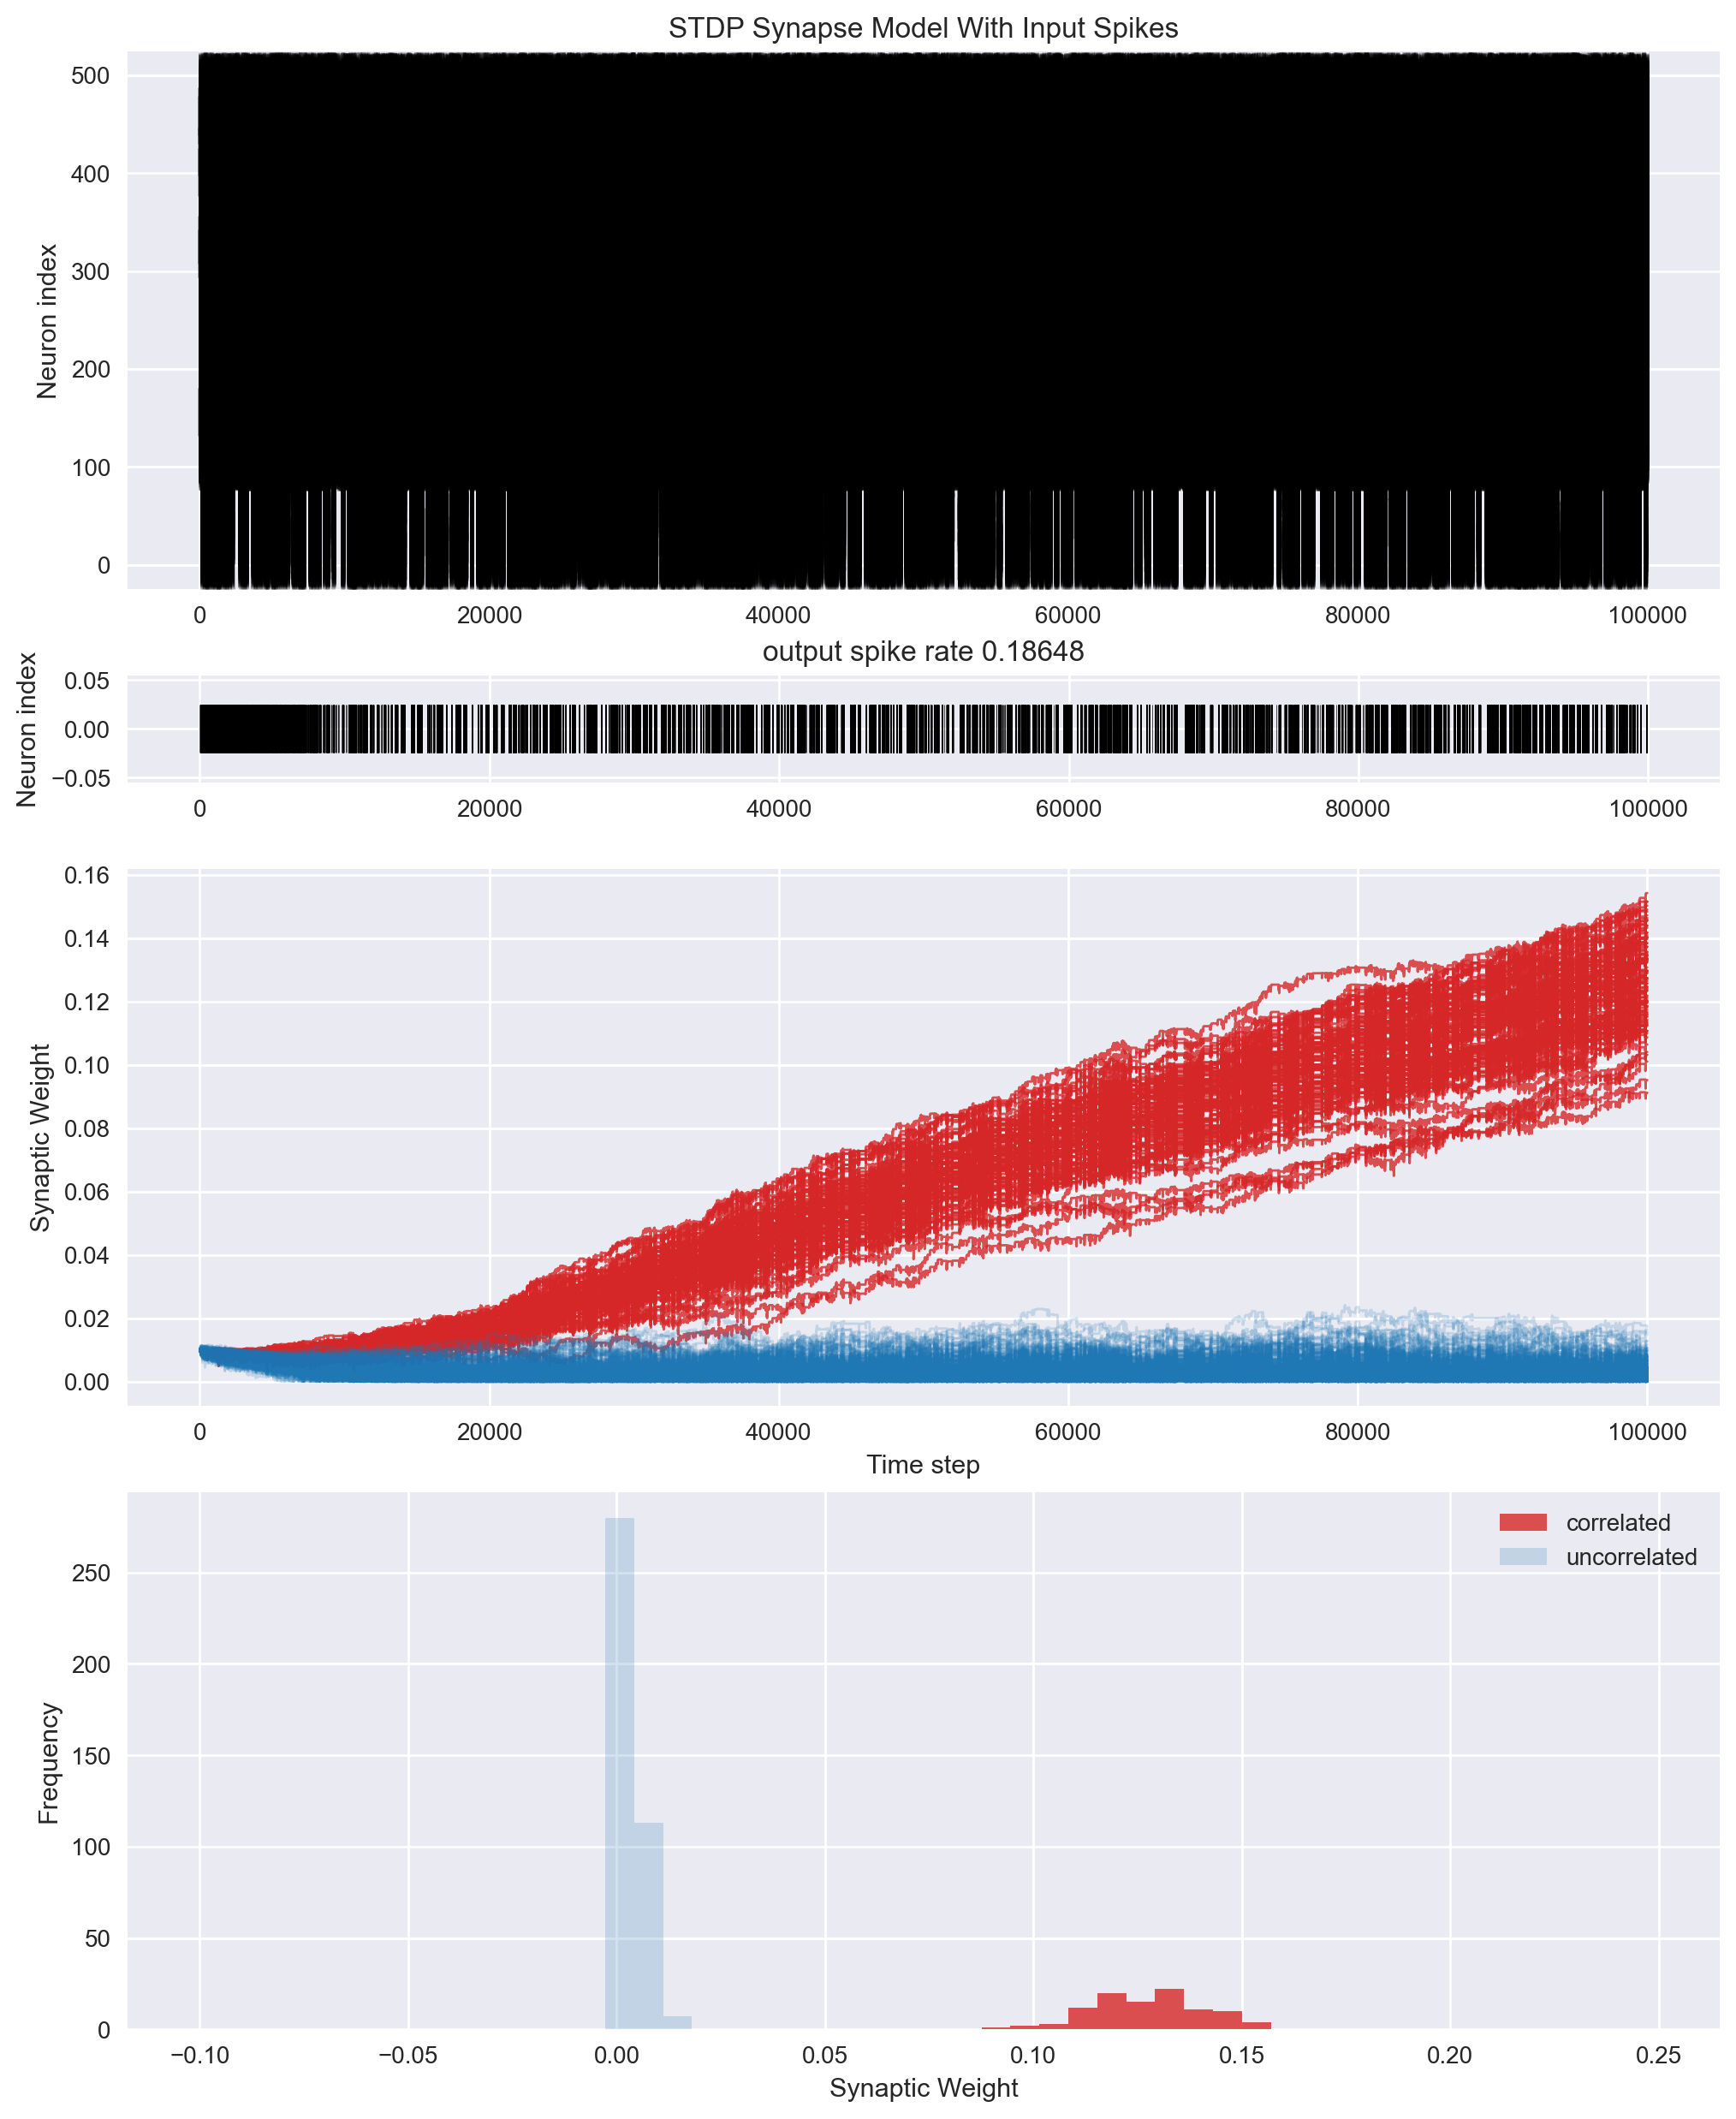

In [3]:
# basic variables
N_pre = 500
N_pre_correlated = 100
N_post = 1
num_steps = 100000

# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.1,
                    A_minus = 0.0088 * 0.024,
                    A_plus = 0.008 * 0.024,)
dt = pars['dt']
time_steps = np.arange(num_steps) * dt
rate = 0.01

# generate the injected spikes with some correlation
cur_in_numpy,_ = random_shifted_trains(dt, num_steps, N_pre, N_pre_correlated , rate = rate, shift_values=[-20,20]) 
cur_in = torch.from_numpy(cur_in_numpy)

# initialize the weights
W = np.random.rand(N_post, N_pre) * pars['w_init_value'] / 100
W = weight_initializer(pars, N_post, I=cur_in_numpy, type_init=2) * pars['w_init_value']  #* np.random.rand(N_post,N_pre) # noise added to appreciate different STDP dynamics
W = torch.from_numpy(W)

# initialize postsynaptic neurons
beta = np.exp(-pars['dt']/pars['tau_m'] *(1+pars['max_g'])) # or 0.8
alpha = np.exp(-pars['dt']/pars['tau_syn_exc']) #or 0.9
rm = 'zero' if pars['hard_reset'] else 'subtract' 
thr = pars['threshold']
post_neurons = [ snn.Synaptic(alpha = alpha, beta = beta, threshold=thr, reset_mechanism=rm) for _ in range(N_post)]

# initialize the tracking variables
mem_record = np.zeros((num_steps+1, N_post))
spk_record = np.zeros((num_steps+1, N_post))
cond_record = np.zeros((num_steps+1, N_post))
mem_record[0,:] = np.asarray([0 for i in range(N_post)])
spk_record[0,:] = np.asarray([0 for i in range(N_post)])
cond_record[0,:] = np.asarray([0 for i in range(N_post)])

# intialize the synapses
my_synapses = STDP_synapse(pars, N_pre, N_post, W_init = W ) # this works even if now W is a tensor!

# run the simulation
start_time = time.time()
for step in range(num_steps):
    # current injected at this time step
    pre_syn_spikes = cur_in[step]
    cur_in_step = W @ pre_syn_spikes

    #spike generated by the layer
    for i in range(N_post):
        spk, cond, mem = post_neurons[i](cur_in_step[i], cond_record[step, i], mem_record[step,i])
        spk_record[step+1,i] = spk
        mem_record[step+1,i] = mem
        cond_record[step+1,i] = cond

    post_syn_spk = spk_record[step+1,:]
    
    # update the weights
    my_synapses.update_weights([pre_syn_spikes.detach().numpy(),post_syn_spk])
    W = my_synapses.W

print(f"Simulation time: {time.time() - start_time:.2f} seconds")

# convert the results to torch tensors
mem_record = torch.from_numpy(mem_record[1:,:])
spk_record = torch.from_numpy(spk_record[1:,:])

weight_history = my_synapses.get_records()['W'][1:,0,:]
plot_raster_weight_distr(cur_in, spk_record, weight_history, N_pre_correlated)



## 1.2 Spotting correlated input with an SNN with 1 FC layer, Synaptic Neuron, offset STDP

Forward pass time : --- 48.13 seconds ---


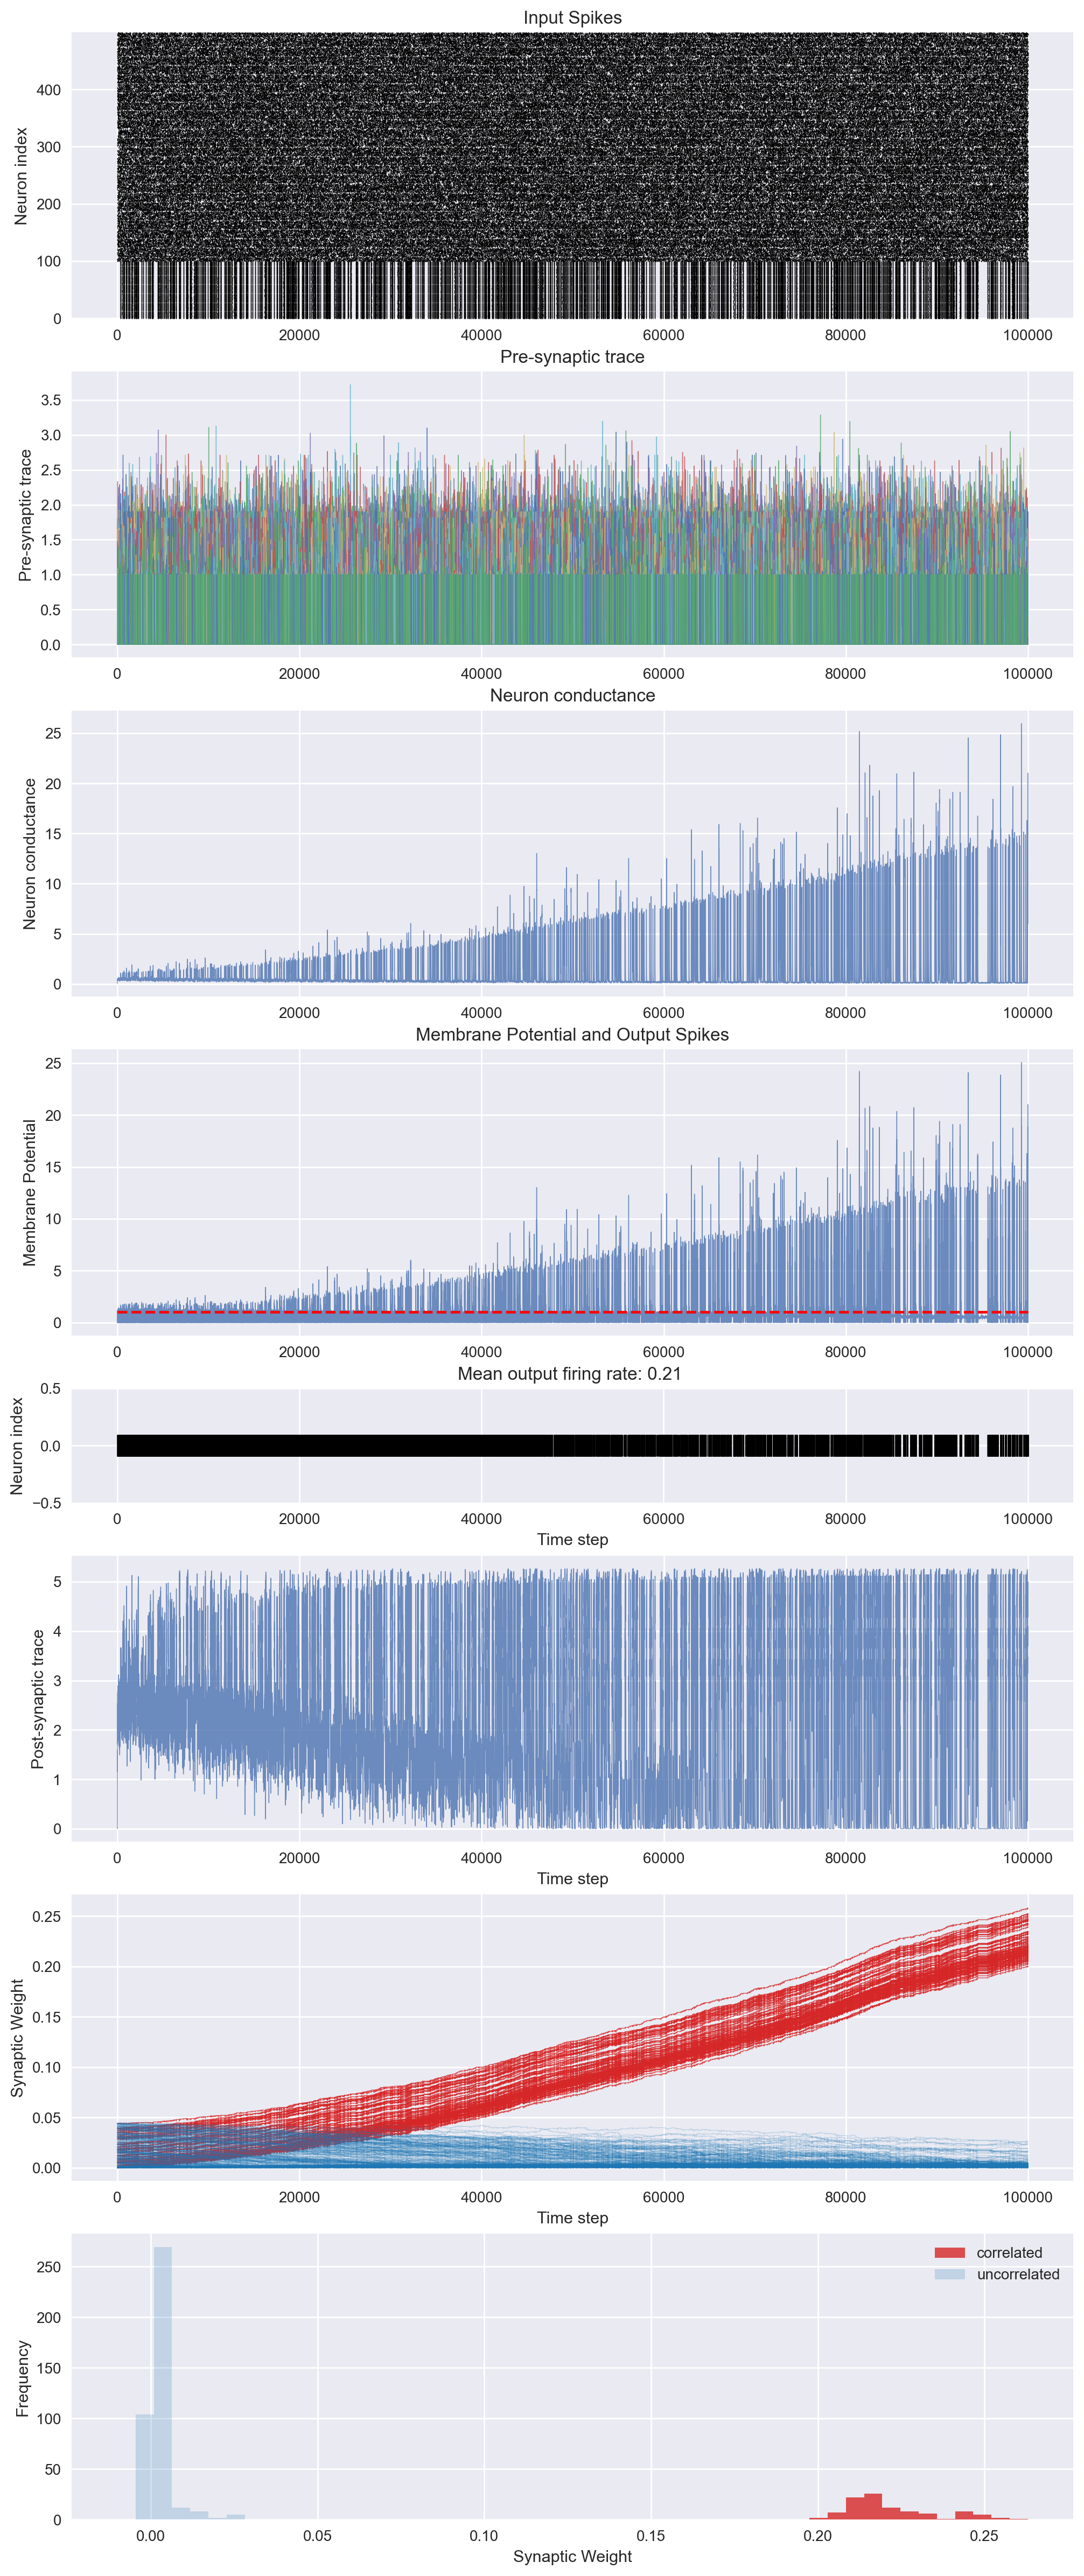

In [4]:
# basic variables
# basic variables
N_pre = 500
N_pre_correlated = 100
N_post = 1
num_steps = 100000
batch_size = 0 # for the moment we do not use batch size
rate = 0.01

class synaptic_stdp(nn.Module):

    def __init__(self, pars, N_pre, N_post = 1):
        super(synaptic_stdp, self).__init__()
        self.pars = pars
        self.alpha = pars.get('alpha', 0.9)
        self.beta = pars.get('beta', 0.8)
        self.w_max = pars.get('w_max', 1.0)
        self.w_min = pars.get('w_min', 0.0)
        self.fc = nn.Linear(N_pre, N_post, bias=False)
        # clamp the weight to positive values
        self.fc.weight.data = torch.clamp(self.fc.weight.data, min=self.w_min, max=self.w_max)
        # set the weight of the layer
        #W_init = weight_initializer(pars, N_pre, N_post, type_init = 3, tensor = True)
        #self.fc.weight = nn.Parameter(W_init)
        reset_mechanism = 'zero' if pars['hard_reset'] else 'subtract'
        self.lif = snn.Synaptic(alpha = self.alpha, beta = self.beta, threshold = pars['threshold'], reset_mechanism = reset_mechanism)

    def forward(self, x):
        # initiliaze the membrane potential and the spike
        cond, mem = self.lif.init_synaptic()

        #tracking variables
        mem_rec = []
        spk_rec = []
        cond_rec = []
        # dovrei inizializzare tutto o come liste o come tensori...
        pre_syn_traces = generate_traces(self.pars, x)
        post_syn_traces = torch.zeros((x.shape[0]+1, N_post))
        weight_history = torch.zeros((x.shape[0]+1, N_post, N_pre))
        weight_history[0,:,:] = self.fc.weight.data

        for step in range(x.shape[0]):
            # run the fc layer
            cur_step = self.fc(x[step])
            # run thw lif neuron
            spk, cond,  mem = self.lif(cur_step, cond, mem)

            # store the membrane potential and the spike
            mem_rec.append(mem)
            spk_rec.append(spk)
            cond_rec.append(cond)

            # updatae post synaptic traces
            beta_minus = self.pars.get('beta_minus',0.9)
            post_syn_traces[step+1, :] = beta_minus*post_syn_traces[step, :] + spk

            # update the weights
            weight_history[step,:,:] = self.fc.weight.data
            A_plus, A_minus = self.pars['A_plus'], self.pars['A_minus']
            LTP = A_plus * torch.outer(spk, pre_syn_traces[step,:]) 
            LTD = A_minus * torch.outer(post_syn_traces[step+1,:], x[step])
            self.fc.weight.data = self.fc.weight.data + LTP - LTD
            # hard constrain on the weights
            self.fc.weight.data = torch.clamp(self.fc.weight.data, min=self.w_min, max=self.w_max)


        post_syn_traces = post_syn_traces[:-1,:]
        weight_history = weight_history[:-1,:,:]

        self.records = {'mem': torch.stack(mem_rec), 
                        'spk': torch.stack(spk_rec), 
                        'cond':  torch.stack(cond_rec), 
                        'pre_trace': pre_syn_traces, 
                        'post_trace': post_syn_traces, 
                        'W': weight_history}

        return 
    
    



# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.012,
                    alpha = 0.9,
                    beta = 0.8,
                    threshold = 1.0,
                    hard_reset = True,
                    A_minus = 0.0088 * 0.024,
                    A_plus = 0.008 * 0.024,
                    beta_minus = 0.9,
                    beta_plus = 0.9)
dt = pars['dt']

# generate the input spikes
cur_in_numpy,_ = random_shifted_trains(dt, num_steps, N_pre, N_pre_correlated , rate = rate, shift_values=[-5,5]) 
cur_in = torch.from_numpy(cur_in_numpy)
cur_in = cur_in.to(dtype = torch.float32, device = device)

# intitilize the model
my_model = synaptic_stdp(pars, N_pre, N_post)

# run the simulation
#my_model.train()
start_time = time.time()
my_model.forward(cur_in)
print(f"Forward pass time : --- {(time.time() - start_time):.2f} seconds ---")
mem_rec, spk_rec, cond_rec, pre_trace, post_trace, weight_history = my_model.records['mem'], my_model.records['spk'], my_model.records['cond'], my_model.records['pre_trace'], my_model.records['post_trace'], my_model.records['W']

# plot results
plot_results_32(dt, cur_in, pre_trace.detach().numpy(), 
                cond_rec.detach().numpy(), 
                mem_rec.detach().numpy(), 
                spk_rec, 
                post_trace.detach().numpy(), 
                weight_history.detach().numpy(), N_pre, N_pre_correlated, N_post, num_steps)


## 1.3 Spotting correlated input with the general SNN that we will use also for the MNIST

Forward pass time : --- 30.96 seconds ---


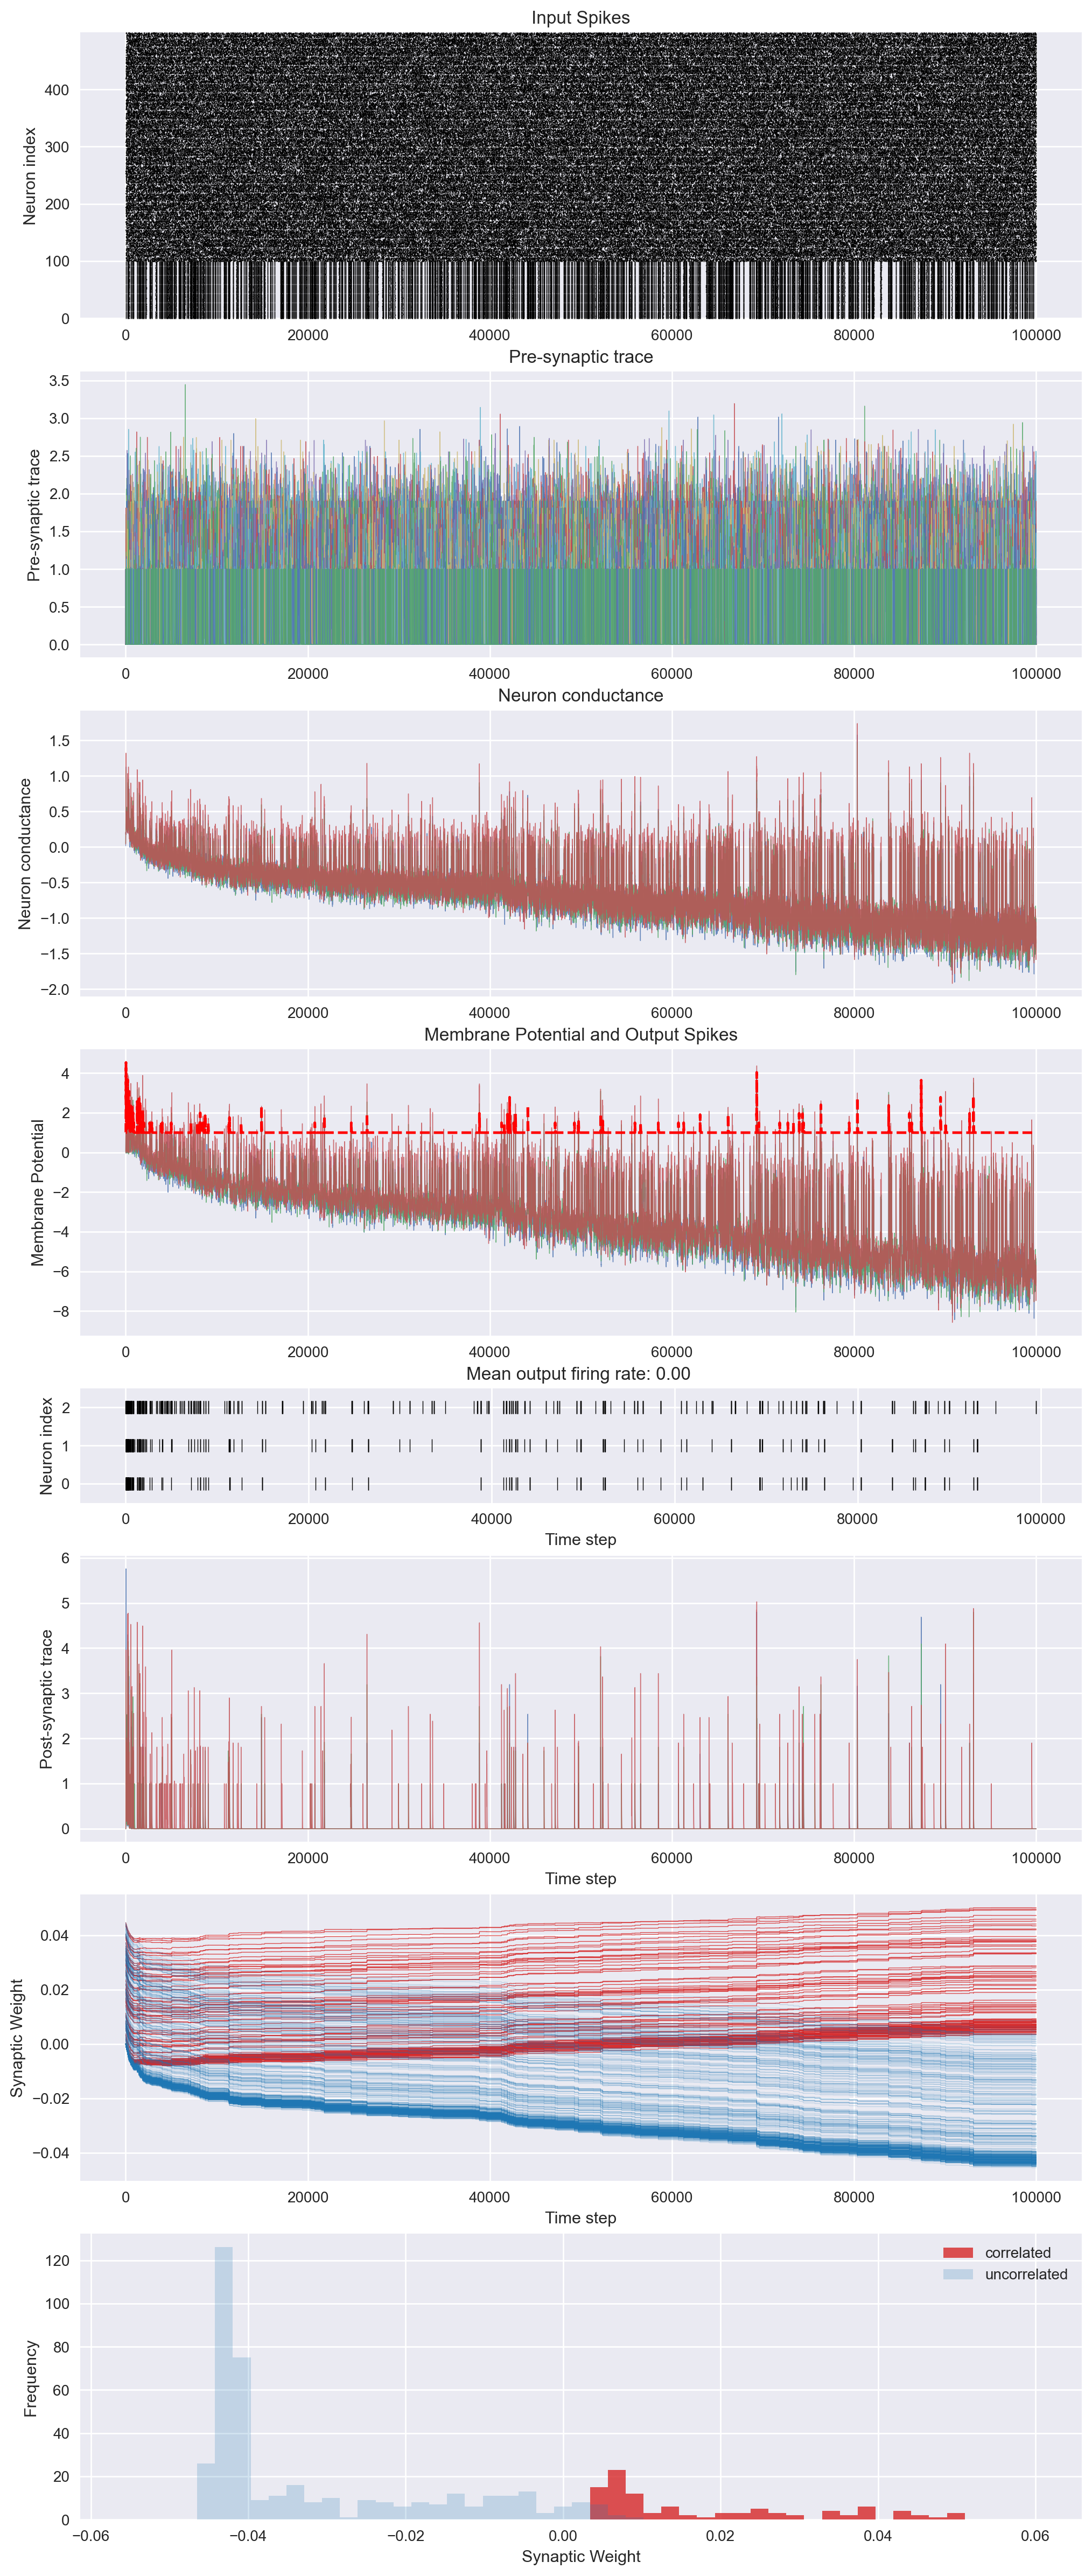

In [5]:
num_steps = 100000
N_pre = 500
N_pre_correlated = 100
rate = 0.01
dt = 1
N_post = 3

pars = mnist_pars(
    STDP_type = 'offset',
    STDP_offset = 0.7,
    num_steps = num_steps,
    A_minus = 0.0088*0.024, 
    A_plus = 0.008*0.024,
    reset_mechanism = 'subtract',
    dynamic_threshold = True,
    tau_theta = 20, 
    theta_add = 0.5,
    refractory_period = False,
    ref_time = 2,
    lateral_inhibition = False,
    lateral_inhibition_strength = 0.1,
    store_subsampling_factor=1
)

# create the input spike trains
cur_in_numpy_base,_ = random_shifted_trains(dt, num_steps, N_pre, N_pre_correlated , rate = rate, shift_values=[-5,5]) 
# add a batch dimension to cur_in_numpy
cur_in_numpy = cur_in_numpy_base[:,None,:]
cur_in = torch.from_numpy(cur_in_numpy)
cur_in_base = torch.from_numpy(cur_in_numpy_base)
cur_in = cur_in.to(dtype = torch.float32, device = device)

model = snn_mnist(pars, N_pre, N_post)
model.eval()

start_time = time.time()
model.forward(cur_in)
print(f"Forward pass time : --- {(time.time() - start_time):.2f} seconds ---")

pre_trace = model.get_records()['pre_trace']
cond_rec = model.get_records()['syn']
mem_rec = model.get_records()['mem']
threshold_rec = model.get_records()['threshold']
spk_rec = model.get_records()['spk']
post_trace = model.get_records()['post_trace']
weight_history = model.get_records()['W']

plot_results_32(dt, cur_in_base, pre_trace, cond_rec, mem_rec, spk_rec, post_trace, weight_history, N_pre, N_pre_correlated, N_post, num_steps, threshold_rec = threshold_rec)

# 2. Digit recognition

## 2.1 MNIST encoding in spike trains

In [6]:
# parameters of the simulation       
batch_size = 50
num_steps = 350
gain = 1.
min_rate = 0.

# Create the datasets
mnist_train = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=gain, min_rate = min_rate, train=True, my_seed = 42)
mnist_test = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=gain, min_rate = min_rate, train=False, my_seed = 42)

# Get the dataloaders
train_loader, val_loader = mnist_train.get_loader()
test_loader = mnist_test.get_loader()

# get the subset loader
subset_loader = mnist_train.get_subset(subset=100) # this was used in a first phase
sub_train, sub_val, sub_test = mnist_train.get_subset_train_val_test(subset = 50)

# check the shape in the loaders and the loader length
print("FULL DATASETS LOADER")
data = iter(train_loader)
data_it, targets_it = next(data)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the train_loader is {len(train_loader)}")

data = iter(val_loader)
data_it, targets_it = next(data)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the val_loader is {len(val_loader)}")

data = iter(test_loader)
data_it, targets_it = next(data)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the test_loader is {len(test_loader)}")
print("")
# check the shape in the subset loaders and the loaders length
print("SUBSET DATASETS LOADER")
data_sub_train = iter(sub_train)
data_it, targets_it = next(data_sub_train)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the sub_train is {len(sub_train)}")

data_sub_val = iter(sub_val)
data_it, targets_it = next(data_sub_val)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the sub_val is {len(sub_val)}")

data_sub_test = iter(sub_test)
data_it, targets_it = next(data_sub_test)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the sub_test is {len(sub_test)}")

# save the animation of a spike image
save_animations = False
if save_animations:
    data = iter(subset_loader)
    data_it, targets_it = next(data)
    spike_data = data_it[:,0,:].view(-1,28,28)  # selectthe first element of the batch
    target = targets_it[0]  
    fig, ax = plt.subplots()
    anim = splt.animator(spike_data, fig, ax)
    #If you're feeling sentimental, you can save the animation: .gif, .mp4 etc.
    anim.save(f"animations/num_steps_{num_steps}-gain_{gain}-min_rate_{min_rate}.mp4")

FULL DATASETS LOADER
Size of a batch of spike data is torch.Size([350, 50, 784])
Length of the train_loader is 1000
Size of a batch of spike data is torch.Size([350, 50, 784])
Length of the val_loader is 200
Size of a batch of spike data is torch.Size([350, 50, 784])
Length of the test_loader is 200

SUBSET DATASETS LOADER
Size of a batch of spike data is torch.Size([350, 50, 784])
Length of the sub_train is 16
Size of a batch of spike data is torch.Size([350, 50, 784])
Length of the sub_val is 4
Size of a batch of spike data is torch.Size([350, 50, 784])
Length of the sub_test is 4


## 2.2 Some preliminaries 

### Class assignment function


In [16]:
num_epochs = 2
num_steps = 100
min_spk_number = 1
pars = mnist_pars(
    STDP_type = 'offset',
    num_steps = num_steps,
    A_minus = 0.0088 ,
    A_plus = 0.008 ,
    reset_mechanism = 'subtract',
    dynamic_threshold = False,
    tau_theta = 5, 
    theta_add = 0.1,
    refractory_period = False,
    ref_time = 2,
    lateral_inhibition = False,
    lateral_inhibition_strength = 1,
    gain = 0.1,
    assignment_confidence = 0.005  # I think at least 1/num_steps
)
N_pre = 28*28
N_post = 100
model = snn_mnist(pars, N_pre, N_post)

# assign some random weights
W = torch.rand(N_post, N_pre) * 0.1 * 1/N_post
model.fc.weight.data = W

df_assignments, df = assign_neurons_to_classes(model, val_loader = subset_loader)

display(df_assignments)
display(df)


assignments conf_status
0            0        True
1            0        True
2            0        True
3            0        True
4            0        True
..         ...         ...
95           0        True
96           0        True
97           0        True
98           0        True
99           0        True

[100 rows x 2 columns]

0          1          2          3          4  \
0              0.461576   0.154430   0.392009   0.357143   0.267748   
1              0.469113   0.188029   0.406607   0.379419   0.275593   
2              0.447783   0.134901   0.357991   0.354189   0.251816   
3              0.486305   0.132948   0.385223   0.366489   0.252155   
4              0.477241   0.127269   0.370580   0.346295   0.263196   
...                 ...        ...        ...        ...        ...   
96             0.464631   0.175118   0.407768   0.379322   0.287845   
97             0.451921   0.157939   0.388705   0.355835   0.266877   
98             0.463842   0.147957   0.404911   0.379806   0.289492   
99             0.452069   0.161266   0.383348   0.350460   0.282615   
sample_count  58.000000  79.000000  64.000000  59.000000  59.000000   

                      5          6          7          8          9  max_index  
0              0.279216   0.339418   0.255161   0.348338   0.253231          0  
1              0.294398   0.356984   0.288249   0.365889   0.272264          0  
2              0.265098   0.310053   0.246175   0.338950   0.242637          0  
3              0.268627   0.304815   0.254700   0.343965   0.239780          0  
4              0.264146   0.314286   0.248341   0.340058   0.241670          0  
...                 ...        ...        ...        ...        ...        ...  
96             0.290420   0.367989   0.264194   0.382391   0.264879          0  
97             0.274902   0.349524   0.271935   0.350962   0.262330          0  
98             0.285770   0.343069   0.282903   0.368980   0.268264          0  
99             0.274174   0.329206   0.270599   0.346647   0.267868          0  
sample_count  51.000000  54.000000  62.000000  49.000000  65.000000          1  

[101 rows x 11 columns]

### Evaluation Function

In [19]:
# modify the assignments to have random classes
for i in range(N_post):
    df_assignments.iloc[i] = np.random.randint(0, 9)

# classify the data in the subset loader
test_accuracy, anspnpi = classify_test_set(model, subset_loader, df_assignments)

display(test_accuracy)
print(f'Average number of spikes per neuron per image: {anspnpi:.2f}')

0.08

Average number of spikes per neuron per image: 110.70


### Training function

In [44]:
num_epochs = 2
min_spk_number = 1
num_steps = 100
pars = mnist_pars(
    STDP_type = 'offset',
    num_steps = num_steps,
    A_minus = 0.00011,
    A_plus = 0.0001 ,
    reset_mechanism = 'zero',
    dynamic_threshold = True,
    tau_theta = 2000, 
    theta_add = 0.25,
    refractory_period = False,
    ref_time = 2,
    lateral_inhibition = True,
    lateral_inhibition_strength = 0.1,
    gain = 0.1,
    use_min_spk_number = False,
    min_spk_number = min_spk_number,
    weight_initialization_type = 'shift'
)

N_pre = 28*28
N_post = 10
model = snn_mnist(pars, N_pre, N_post)

# Train the model
start_time = time.time()
model = train_model(model, 
                    train_loader = sub_train, 
                    val_loader = sub_val,
                    num_epochs = num_epochs, 
                    )
print(f' The total training time is {time.time() - start_time:.2f} seconds')

# print the ram size of records_full
print(f"The size of records is {sys.getsizeof(model.get_records())/1e3:.2f} KB")

# plot the results
start_time = time.time()
model.plot_simulation()
print(f' The total plotting time is {time.time() - start_time:.2f} seconds')

100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.07s/batch, ANSPNPI=1.50e+02, acc=0.1125, time=8.53s]

 The total training time is 17.25 seconds


RuntimeError: stack expects a non-empty TensorList

In [9]:
print(f'the forward count is {model.forward_count}')
print(f'the batch size is {model.batch_size}')
print(f'the num steps is {model.num_steps}')
print(f'The total simulation time is {model.tot_sim_time:.2f} seconds')
print(f'subsampling rate of records is {model.t}')

# check that the records have all the correct shapes
records = model.get_records()
for key in records.keys():
    print(f'{key} has shape {records[key].shape}')

the forward count is 24
the batch size is 50
the num steps is 100
The total simulation time is 120000.00 seconds
subsampling rate of records is 10
mem has shape (12000, 10)
spk has shape torch.Size([120000, 10])
syn has shape (12000, 10)
threshold has shape (12000, 10)
pre_trace has shape (12000, 784)
post_trace has shape (12000, 10)
W has shape (240, 10, 784)


## 2.3 Hyperparameters Tuning

### Classic STDP

#### Rate stabilization

In [15]:
STDP_classic_hpo = snn_hpo('classic',n_trials=10000-3846,timeout = 36000)
STDP_classic_hpo.initialize_rate_study()   

[I 2024-03-15 16:25:19,593] Using an existing study with name 'classic_STDP_stab_rate' instead of creating a new one.


In [16]:
%%capture
start_time = time.time()
STDP_classic_hpo.optimize_rate()
print(f' The total optimization time is {time.time() - start_time:.2f} seconds')

[I 2024-03-15 16:25:42,070] Trial 3853 pruned. 
[I 2024-03-15 16:25:42,644] Trial 3848 pruned. 
[I 2024-03-15 16:25:42,646] Trial 3846 pruned. 
[I 2024-03-15 16:25:43,076] Trial 3849 pruned. 
[I 2024-03-15 16:25:43,083] Trial 3847 pruned. 
[I 2024-03-15 16:25:43,525] Trial 3851 pruned. 
[I 2024-03-15 16:25:43,528] Trial 3850 pruned. 
[I 2024-03-15 16:25:43,534] Trial 3852 pruned. 
[I 2024-03-15 16:25:51,670] Trial 3855 pruned. 
[I 2024-03-15 16:25:52,190] Trial 3854 pruned. 
[I 2024-03-15 16:25:52,251] Trial 3856 pruned. 
[I 2024-03-15 16:25:58,980] Trial 3863 pruned. 
[I 2024-03-15 16:25:59,480] Trial 3862 pruned. 
[I 2024-03-15 16:25:59,612] Trial 3864 pruned. 
[I 2024-03-15 16:26:06,244] Trial 3866 pruned. 
[I 2024-03-15 16:26:06,784] Trial 3859 pruned. 
[I 2024-03-15 16:26:06,917] Trial 3865 pruned. 
[I 2024-03-15 16:26:06,919] Trial 3867 pruned. 
[I 2024-03-15 16:26:14,545] Trial 3857 pruned. 
[I 2024-03-15 16:26:15,141] Trial 3871 pruned. 
[I 2024-03-15 16:26:15,787] Trial 3869 p

In [ ]:
print(f' The total optimization time is {time.time() - start_time:.2f} seconds')

Study for the rate stabilization statistics of classic STDP: 

  Number of finished trials: 3846
  Number of pruned trials: 3205
  Number of complete trials: 634
Best trial:
  Value: 5.803049723908806
  Params: 
    min_rate: 0.0
    gain: 0.5
    weight_initializer: random
    A_minus: 0.0009868951752536814
    A_plus: 1.4204859722926078e-05
    theta_add: 0.0
    ref_time: 8
Best Ranges
A_minus: 1.05e-05 - 1.00e-03
A_plus: 1.00e-06 - 9.65e-05


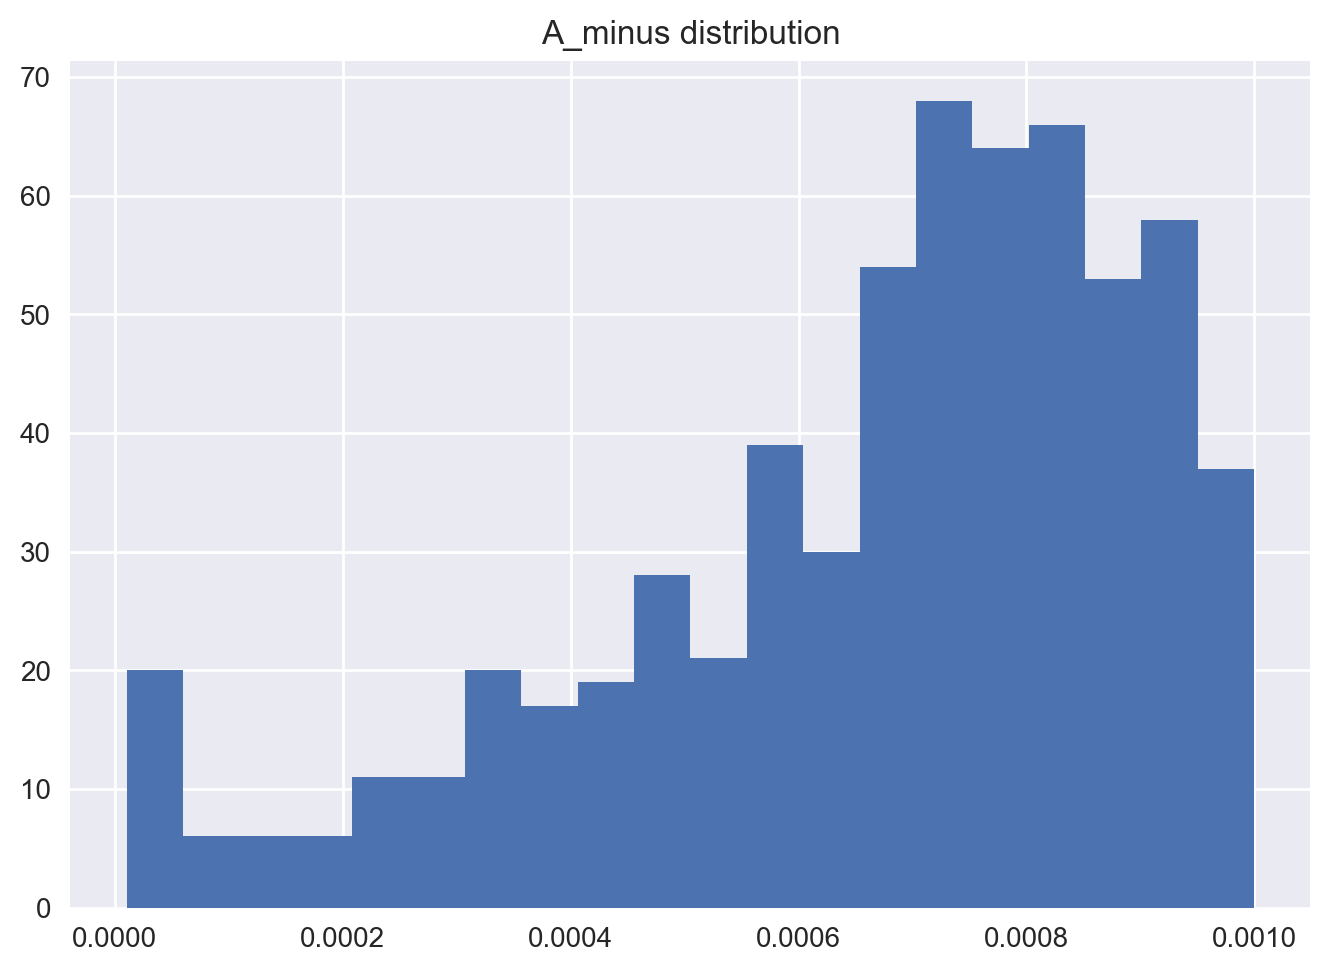

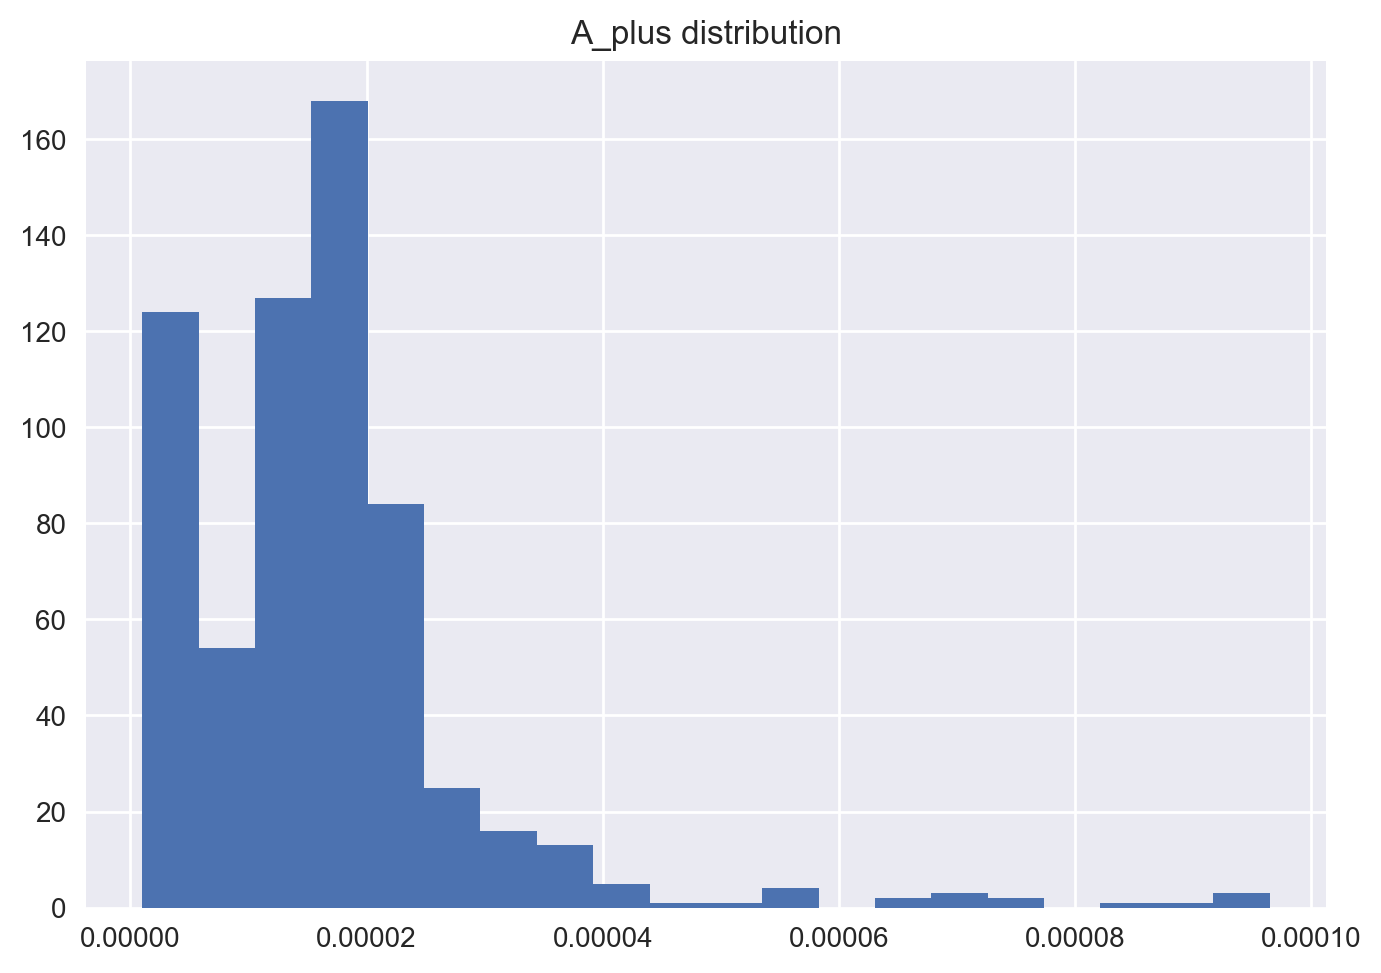

In [12]:
STDP_classic_hpo.print_statistics()

In [ ]:
STDP_classic_hpo.study_rate.trials_dataframe().sort_values(by='value', ascending=True)

In [ ]:
display(plot_optimization_history(STDP_classic_hpo.study_rate))
display(plot_intermediate_values(STDP_classic_hpo.study_rate))

In [ ]:
display(plot_param_importances(STDP_classic_hpo.study_rate))
optuna.visualization.plot_param_importances(
    STDP_classic_hpo.study_rate, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

#### Optimize the accuracy

In [6]:
STDP_classic_hpo.initialize_accuracy_study()

[I 2024-03-13 18:07:32,325] A new study created in RDB with name: classic_STDP_optimize_accuracy


In [ ]:
#%%capture
STDP_classic_hpo.optimize_accuracy()

In [ ]:
STDP_classic_hpo.print_statistics()

### Asymptotic STDP

#### Rate stabilization

In [7]:
STDP_asymptotic_hpo = snn_hpo('asymptotic',n_trials=10000,timeout = 36000)
STDP_asymptotic_hpo.initialize_rate_study()

[I 2024-03-15 08:41:29,726] A new study created in RDB with name: asymptotic_STDP_stab_rate


In [ ]:
%%capture
start_time = time.time()
STDP_asymptotic_hpo.optimize_rate()
# print(f' The total optimization time is {time.time() - start_time:.2f} seconds')# The total optimization time is 25076.69 seconds


Study for the rate stabilization statistics of asymptotic STDP: 

  Number of finished trials: 10000
  Number of pruned trials: 8126
  Number of complete trials: 1874
Best trial:
  Value: 3.131483941956515
  Params: 
    min_rate: 0.0
    gain: 0.5
    weight_initializer: norm_row
    A_minus: 9.966402370361568
    A_plus: 0.0004278119087765766
    theta_add: 0.0
    ref_time: 2
Best Ranges
A_minus: 2.32e+00 - 1.00e+01
A_plus: 1.00e-04 - 5.05e-03


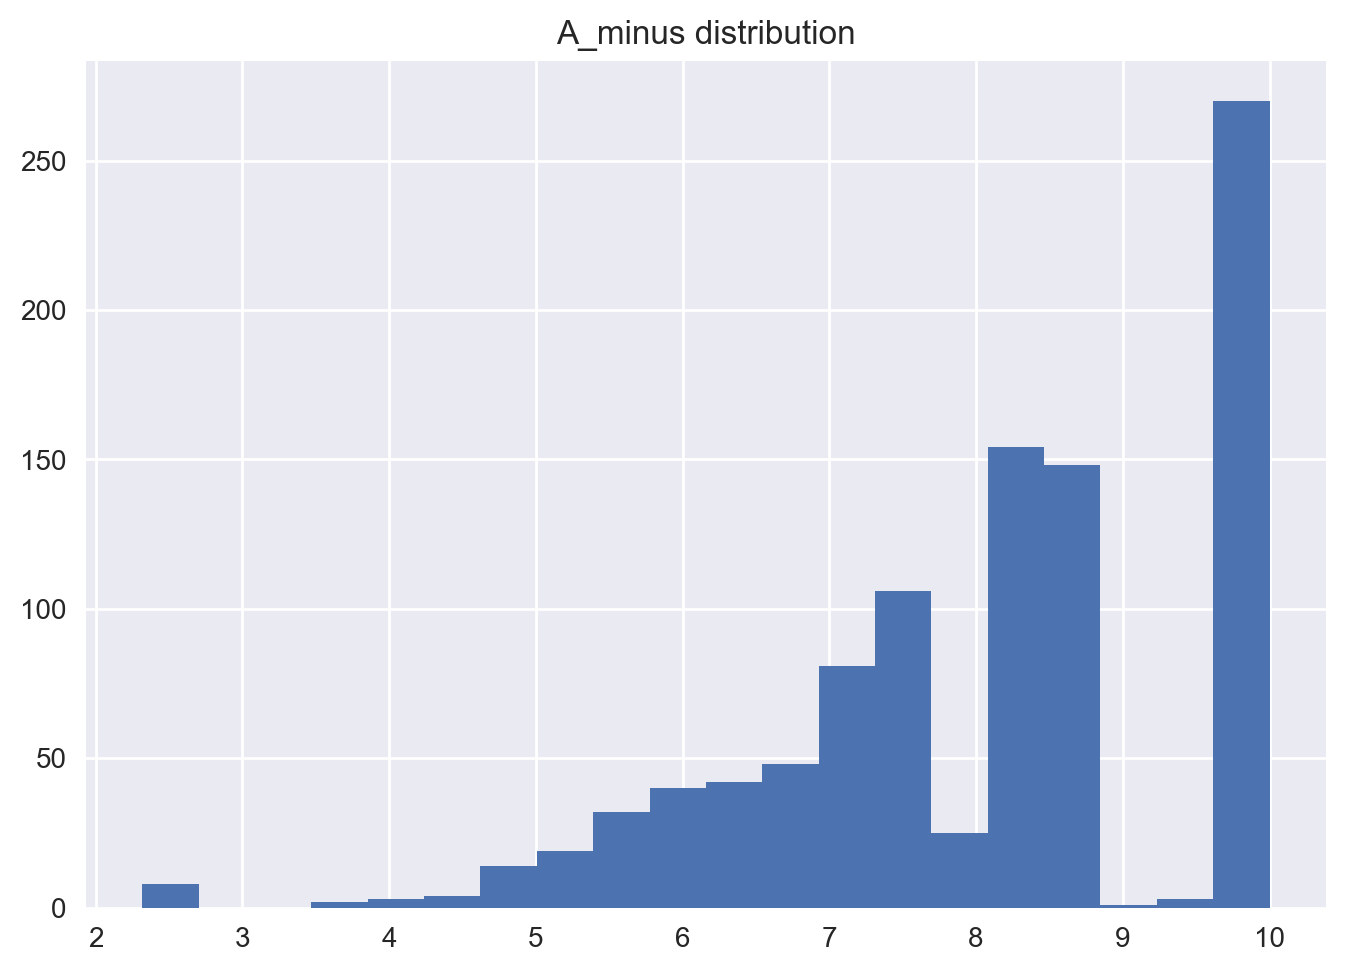

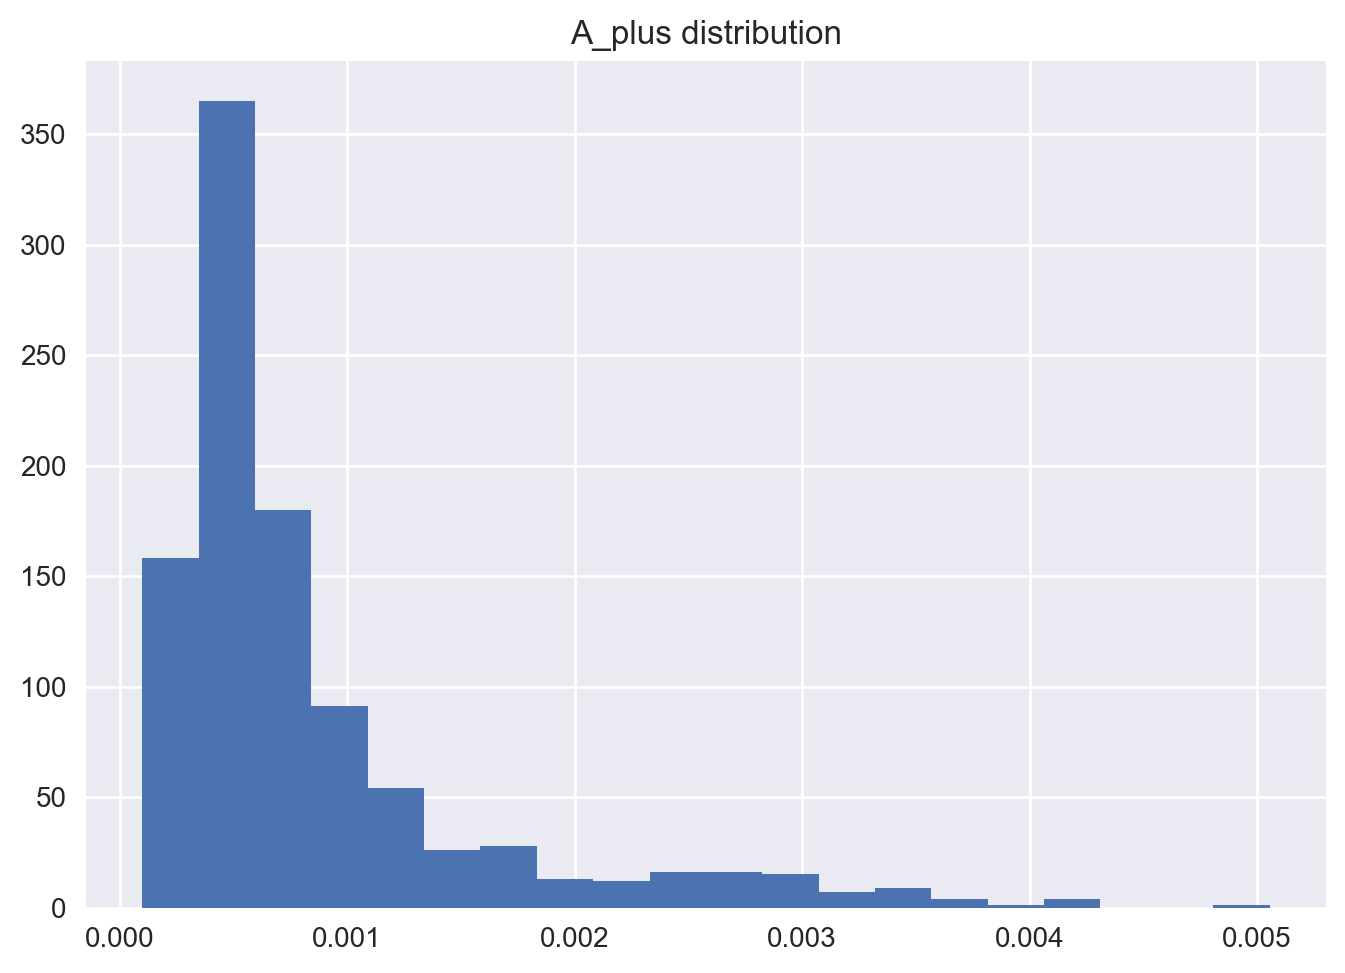

In [13]:
STDP_asymptotic_hpo.print_statistics()

In [ ]:
STDP_asymptotic_hpo.study_rate.trials_dataframe().sort_values(by='value', ascending=True)

In [ ]:
display(plot_optimization_history(STDP_asymptotic_hpo.study_rate))
display(plot_intermediate_values(STDP_asymptotic_hpo.study_rate))

In [ ]:
display(plot_param_importances(STDP_asymptotic_hpo.study_rate))
optuna.visualization.plot_param_importances(
    STDP_asymptotic_hpo.study_rate, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

#### Optimize the accuracy

In [ ]:
STDP_asymptotic_hpo.initialize_accuracy_study()

In [ ]:
%%capture
STDP_asymptotic_hpo.optimize_accuracy()

In [ ]:
STDP_asymptotic_hpo.print_statistics()

### Offset STDP

#### Rate stabilization

In [2]:
STDP_offset_hpo = snn_hpo('offset',n_trials=10000,timeout = 36000)
STDP_offset_hpo.initialize_rate_study()

[I 2024-03-15 08:19:32,411] Using an existing study with name 'offset_STDP_stab_rate' instead of creating a new one.


In [ ]:
%%capture
STDP_offset_hpo.optimize_rate()

Study for the rate stabilization statistics of offset STDP: 

  Number of finished trials: 10000
  Number of pruned trials: 6469
  Number of complete trials: 3531
Best trial:
  Value: 6.114126542236917
  Params: 
    min_rate: 0.0
    gain: 0.5
    weight_initializer: norm_row
    STDP_offset: 0.3067446062406656
    learn_rate: 0.04894892515177093
    theta_add: 0.0
    ref_time: 8
Best Ranges
learning_rate: 1.45e-05 - 1.00e-01
STDP_offset: 1.08e-04 - 5.86e-01


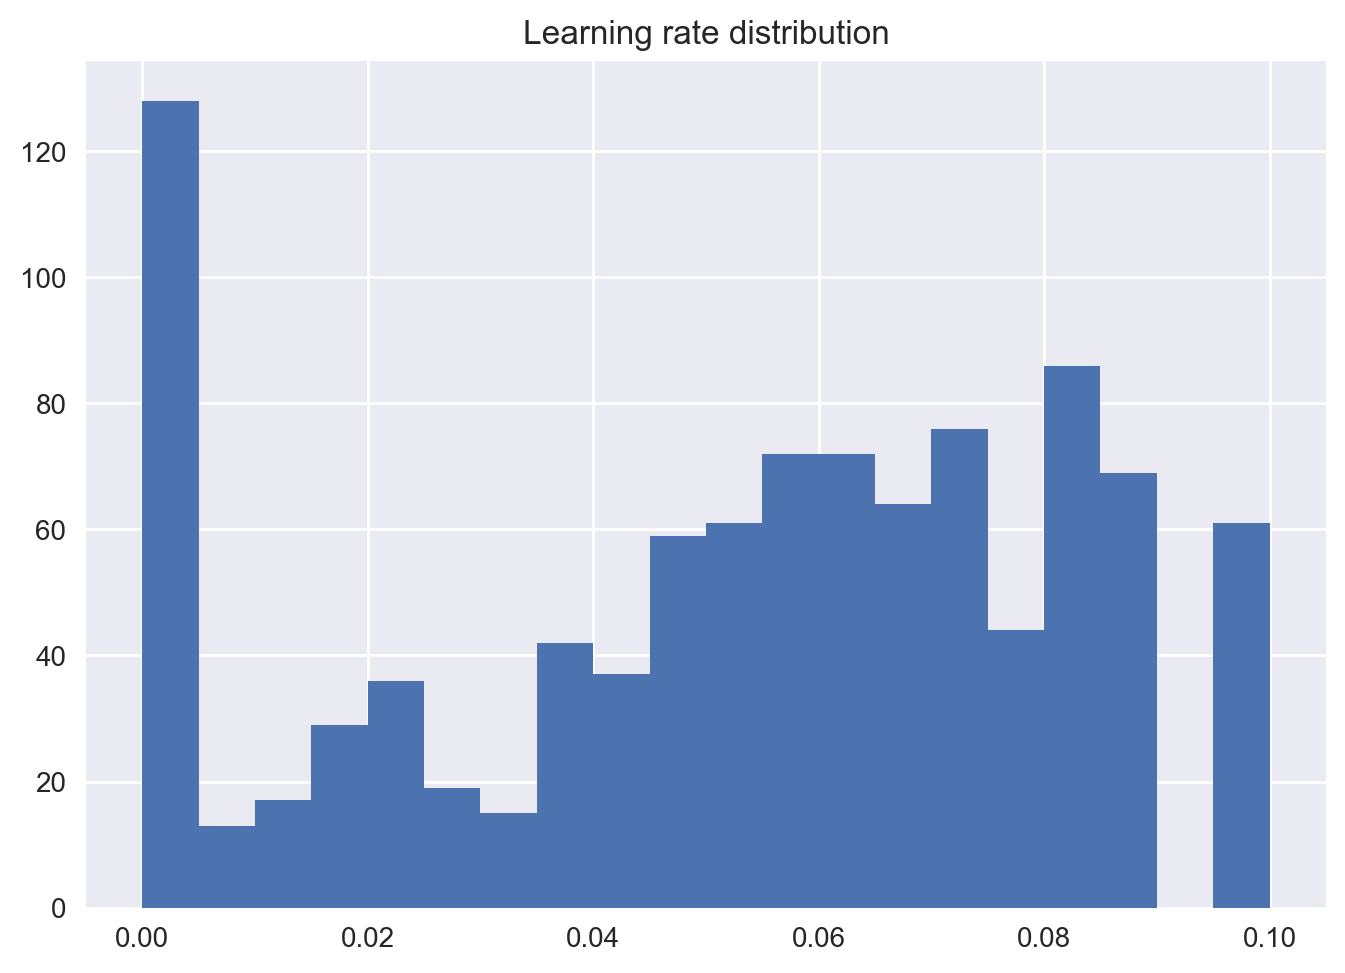

In [14]:
STDP_offset_hpo.print_statistics()

In [ ]:
STDP_offset_hpo.study_rate.trials_dataframe().sort_values(by='value', ascending=True)

In [ ]:
display(plot_optimization_history(STDP_offset_hpo.study_rate))
display(plot_intermediate_values(STDP_offset_hpo.study_rate))

In [ ]:
display(plot_param_importances(STDP_offset_hpo.study_rate))
optuna.visualization.plot_param_importances(
    STDP_offset_hpo.study_rate, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

#### Optimize the accuracy

In [ ]:
STDP_offset_hpo.initialize_rate_study()

In [ ]:
%%capture
STDP_offset_hpo.optimize_rate()

In [ ]:
STDP_offset_hpo.print_statistics()

## 2.3 Training

In [33]:
# to be done
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# let's find some range for each STDP type
# classic
# parameters of the simulation
pars = mnist_pars(
    STDP_type = 'asymptotic',
    A_minus = 0.1, 
    A_plus = 0.08,
    STDP_offset = 2.,
    learning_rate = 0.1,
    reset_mechanism = 'subtract',
    dynamic_threshold = True,
    tau_theta = 1000, 
    theta_add = 2.,
    refractory_period = True,
    ref_time = 50,
    lateral_inhibition = True,
    lateral_inhibition_strength = 0.75,
    min_spk_number = 1,
    t = 10,
    weight_initialization_type = 'shift',
    store_records = True,
    assignment_confidence = 0.00001
)

input_size = 28*28
output_size = 100
num_steps = 300
batch_size = 200
num_epochs = 5
gain = 0.5
min_rate = 0.01

# Create the datasets
mnist_train = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=gain, min_rate = min_rate, train=True, my_seed = 42)
mnist_test = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=gain, min_rate = min_rate, train=False, my_seed = 42)

# Get the dataloaders
train_loader, val_loader = mnist_train.get_loader()
test_loader = mnist_test.get_loader()
sub_train, sub_val, sub_test = mnist_train.get_subset_train_val_test(subset = 50)
print(f"The length of the train is {len(sub_train)*batch_size}")
print(f"The length of the val is {len(sub_val)*batch_size}")
print(f"The length of the test is {len(sub_test)*batch_size}")


# create the model
model = snn_mnist(pars, input_size, output_size)
model.to(device)

# Train the model
start_time = time.time()
model = train_model(model, 
                    train_loader = sub_train, 
                    val_loader = sub_val,
                    num_epochs = num_epochs
                    )

print(f' The total training time is {time.time() - start_time:.2f} seconds')

# # get the ram size if the records
# print(f"The size of records is {sys.getsizeof(model.get_records())/1e3:.2f} KB")

# compute the assigned classes
assignments_df, df = assign_neurons_to_classes(model, val_loader = sub_val)
display(df.max_index.value_counts())

# test the model
test_accuracy, anspnpi = classify_test_set(model, sub_test, assignments_df)
display(test_accuracy)



The length of the train is 800
The length of the val is 200
The length of the test is 200


100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/batch, ANSPNPI=6.00e+00, acc=0.0000, time=8.56s]


 The total training time is 42.50 seconds


max_index
0    100
2      1
Name: count, dtype: int64

0.0

In [34]:
torch.stack(model.synapse_records['pre_trace']).mean()

tensor(1.9395, dtype=torch.float16)

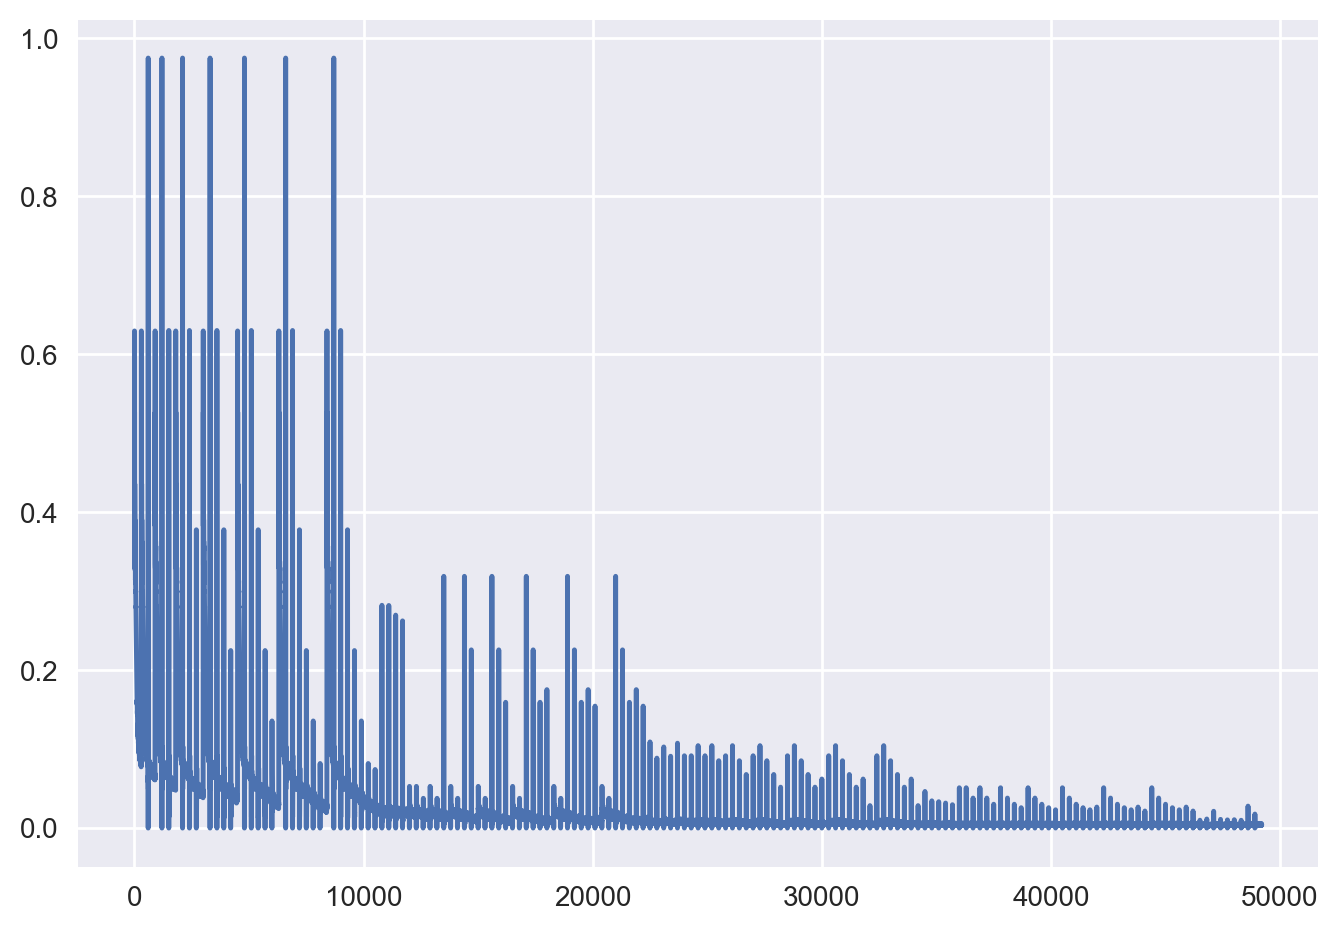

In [6]:
# plot the following vector
vector = np.concatenate(model.asrpts)
plt.plot(vector)
plt.show()


In [ ]:
# # plot the results
# # this function does not work anymore
# start_time = time.time()
# model.plot_simulation(neuron_index=4)
# print(f' The total plotting time is {time.time() - start_time:.2f} seconds')

In [ ]:
# display(np.load(r".\random\AeAi.npy").shape)
# display(np.load(r".\random\AiAe.npy").shape)
# display(np.load(r".\random\XeAe.npy").shape)
# display(np.load(r".\random\XeAi.npy").shape)
# display(np.load(r".\weights\theta_A.npy").shape)
# display(np.load(r".\weights\XeAe.npy").shape)
# display(np.load(r".\random\XeAe.npy")[:,2].reshape(400,784).min()) # this is the real matrix of weights
# display(np.load(r".\random\XeAe.npy")[:,2].reshape(400,784).max())

